# Tutorial: Getting Started With *joe*

Written by Adam Morgan

*Last Updated August 1, 2024*

Welcome to *joe*! In this tutorial we'll go through a rapid introduction to the basic numerical methods used in *joe*, then solve our first initial-value problem using *joe*. 

Please direct any questions, comments, or criticism to adam.morgan@mail.utoronto.ca 

## A Tiny Bit of Background

*joe* generates approximate solutions to evolutionary partial differential equations (PDEs). Currently, *joe* only supports finding **real-valued** solutions depending only on **one space variable** $x$ (as well as a single time variable $t$). The spatial domain for our solution $u(x,t)$ is either a closed, symmetric interval with periodic boundary conditions (topologically equivalent to the unit circle $S^1$), or the real line $\mathbb{R}$: in the latter case, we impose the "boundary condition" that $u(x,t)$ vanishes rapidly at spatial infinity. Being able to deal with both of these boundary conditions makes *joe* well-suited to handling reaction-diffusion equations **and** nonlinear dispersive equations. 

*joe* discretizes the spatial derivatives in a PDE using the **fast Fourier transform (FFT)**. This diagonalizes the linear, constant-coefficient part of the PDE in question, which in turn greatly simplifies time-stepping. 

In *joe*, explicit and (formally) fourth-order accurate time-stepping may be performed using two different methods: **integrating factor Runge-Kutta 4 (IFRK4)** or **exponential time differencing Runge-Kutta 4 (ETDRK4)**. For debugging purposes, *joe* also supports first-order accurate time-stepping with the **exponential Euler method (ETD1)**. Crucially, using exponential methods means *joe* can solve stiff PDEs without having to resort to a slow implicit method! Additionally, by default *joe* saves all the matrix exponentials and **$\phi$-functions** ($\approx$ exponential Runge-Kutta weights) it computes, and loads them when they are required, making time-stepping even faster. 

Once a time-step in the Fourier domain is completed, we may use the **inverse fast Fourier transform (IFFT)** to obtain our solution in the (physical) spatial domain. In the language of scientific computing, the FFT-based solution strategy in *joe* is called a **spectral method**. As long as $u(x,t)$ is smooth, spectral methods can reproduce $u(x,t)$ with high accuracy and great speed (owing to the "fast" in "fast Fourier transform"). So, *joe* uses fast methods to approximate spatial derivatives and fast methods to perform time-stepping. 

Now, in order to compute the FFT of $u(x,t)$ accurately, we have to treat this function as if it's a function on the unit circle $S^1$: this is because the FFT is really just the Fourier transform on a uniform lattice approximation of the circle ($\simeq \mathbb{Z}_{N}$, where $N$ is the number of spatial grid points we sample). Of course, if $u(x,t)$ is subject to periodic boundary conditions this definitely holds and we have nothing to worry about. However, if $u(x,t)$ is supposed to be defined for all $x\in \mathbb{R}$, we need to do a little more work. 

1) First, we pick $L\gg 1$ and treat $u(x,t)$ as a function on $[-L, L] \approx \mathbb{R}$. 

2) We then artificially impose periodic boundary conditions on $u(x,t)$. This will work fine as long as $u$ is zero in suitably thick layers about $\pm L$. 

3) To prevent the artificial periodic boundary conditions from causing trouble when our simulations are long enough for $u$ to be *nonzero* near $\pm L$, we introduce a **sponge layer**. This adds a heat-equation-like term to the governing PDE that "turns on" only in a neighbourhood of the boundary: since heat flow rapidly decreases amplitude, the idea is that once the solution leaks into the sponge layer around $x=+L$ it is damped to zero before it can emerge from $x=-L$ and pollute the  approximation. The part of the solution that gets sent to zero in the sponge layer can be though of as having "gone off to infinity". 


Of course, using sponge layers means that we can only really trust our numerical solution on a smaller subinterval of $[-L, L]$, say, $[-0.5L, 0.5L]$. Additionally, having to perform a step of heat flow requires a linear solve, which can be a bit expensive. However, the sum cost of these issues is still a small price to pay for the rapidity and accuracy of FFT-based differentiation! 

In summary, *joe* quickly and accurately solves PDEs defined on $S^1$ or $\mathbb{R}$ using three key ingredients: 

1) spectral approximation of derivatives; 

2) fourth-order (explicit!) exponential time-stepping; 

3) the use of sponge layers to let waves "go off to infinity". 

### Recommendations for Further Reading 

#### Spectral Methods
- Trefethen, *Spectral Methods in MATLAB*, SIAM, 2000

- Boyd, *Chebyshev and Fourier Spectral Methods*, second rev. edition, Dover, 2001

#### Exponential Integrators
- Cox & Matthews, JCP, 2002 https://doi.org/10.1006/jcph.2002.6995

- Kassam & Trefethen, SIAM JSC, 2005 https://epubs.siam.org/doi/10.1137/S1064827502410633

- Klein, ETNA, 2007 https://eudml.org/doc/117659

- Hochbruck & Ostermann, Acta Numerica, 2010 https://doi.org/10.1017/S0962492910000048

- Bowman & Zoto, arxiv preprint, 2023 https://arxiv.org/pdf/2303.12139.pdf

#### Sponge Layers
- Bronski, Physica D, 1998 https://www.sciencedirect.com/science/article/pii/S0167278998001377

- Liu and Trogdon, Appl. Num. Math., 2023 https://www.sciencedirect.com/science/article/abs/pii/S0168927423001526

For basic Python-based tutorials on spectral differentiation and exponential integrators written by yours truly, see the following github links: 

1) https://github.com/ageorgemorgan/teaching/blob/main/spectral_differentiation_periodic.ipynb

2) https://github.com/ageorgemorgan/teaching/blob/main/expint_basic.ipynb

### What *joe* Cannot Do, and What it Struggles With 

Now that we understand the broad strokes related to how and why *joe* works, I'll briefly go through some of its limitations.

Here are limitations that will be handled in the short term: *joe* cannot...
- solve PDEs having complex-valued solutions;
- solve PDEs for functions having more than one spatial unknown;
- solve PDEs that are order three or greater in time. 

Here are the more serious limitations on *joe*'s performance and versatility. 
- *joe* works on PDEs of the form

$$
u_{t} +iL\left(\frac{1}{i}\partial_{x}\right)u + f(x,t,u,u_{x}, u_{xx},...) = 0,
$$

where $L$ is a multiplier with *no dependence on $x$*. So, equations where all terms have variable coefficients are off the table.

- *joe* does not support spatial or temporal adaptivity. To my knowledge, even just temporal adaptivity for exponential methods is not yet well-understood! 

- *joe* is based around spectral methods, so it cannot deal with discontinuous solutions such as shock waves. For smooth but rapidly varying solutions, *joe*'s spectral methods may still have trouble owing to the Gibbs phenomenon. 

- While sponge layers do work, they are necessarily parametric (one must choose the computational domain size, sponge layer thickness, damping coefficient, and more). Thus, when using sponge layers in *joe* one may have to get "under the hood" while parameter tuning, in turn making *joe* lose some of its ease-of-use. 

## Code Demo

We'll see how to simulate a solution to the **Benjamin-Bona-Mahony equation (BBM)**

$$
u_{t}-u_{xxt}+u_{xxx} + 6uu_{x} = 0, \quad x\in \mathbb{R}, \ t\geq 0, 
$$

a model of long-wavelength, small-amplitude gravity waves in shallow water. For further physical and mathematical background on this equation, see Benjamin et al 1972 https://www.jstor.org/stable/74079 or Albert and Bona 1991 https://link.springer.com/article/10.1007/BF01238818. If we denote our Fourier frequency variable by $k$ and the Fourier transform of $u$ by $\widehat{u}$, BBM may be written in Fourier space as

$$
\widehat{u}_{t} + i\frac{k^3}{1+k^2} \widehat{u} -\frac{3ik}{1+k^2}\left(u^2\right)^{\wedge}(k) = 0 . 
$$

For large $|k|$, the $k$-dependence of the linear term is $\mathcal{O}\left(|k|\right)$, so this equation is mildly stiff (*joe* can certainly handle a lot worse!). 

*A pedantic physics remark: we are studying BBM moving in the frame of the fastest linear waves, so our linear dispersive term looks a bit different than the one the reader may be used to seeing.*

We want to get a solution $u(x,t)$ defined on a large subinterval of $\mathbb{R}$ that vanishes quickly at infinity, so we will encounter sponge layers! Additionally, we impose the initial condition 
$$
u(x,0) = 6e^{-x^2}
$$
(compare with Appendix A, Fig. 15 in Liu & Trogdon 2023). 

### Set Up Extra Python Stuff

In [1]:
# First, unless you're running this notebook in the directory joe_main,
# you need to navigate to where you've unpacked the joe-main folder w/ code like this:
# import os 
# os.chdir(‘path to folder’) # e.g. os.chdir('/user/Downloads/joe-main')

# for scientific computing needs
import numpy as np

from numpy.fft import fft, ifft

# import some joe stuff
from joe_main_lib import model, initial_state, simulation

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Initializing a Simulation

First, we prescribe what PDE we want to solve. In *joe*, this is done by creating a $\texttt{model}$ (as in "model PDE") object. To input the Fourier-transformed PDE

$$
\partial_{t}^{m} \widehat{u} + iL\left(k\right)\widehat{u} + \widehat{f(u)} = 0,
$$

into *joe*, one initializes a $\texttt{model}$ object with the following attributes: 

- $\texttt{t\_ord} = m $
- $\texttt{symbol} = L(k)$ (a callable with one argument)
- $\texttt{fourier\_forcing} = \widehat{f(u)}$ (a callable with three arguments $V, k ,x$, **in that order!**).

To concretize this discussion, note that for BBM we have

- $m=1$

- $L(k) = \frac{k^3}{1+k^2}$

- $\widehat{f} = -\frac{3ik}{1+k^2}\left(u^2\right)^{\wedge}$. 

In this case, the forcing has no explicit dependence on the spatial variable $x$ (it depends on $x$ only through $u$). In principle, however, the nonlinear term may look like
$$
f(u,x) = a(x)u^2
$$
for some function $a(x)$, and for this reason the $\texttt{fourier\_forcing}$ callable must take in $x$ as an argument. 

Fortunately, BBM is one of the PDEs that's built into *joe*, so we can just load it up with the following code: 

In [2]:
from models import builtin_model # access a fnc. to load built-in models from the "models" script
model_kw = 'bbm' # put in the name of the model equation 
my_model = builtin_model(model_kw, nonlinear=True) # load your model object 

Alternatively, we could build our $\texttt{model}$ object from scratch using the following script: 

In [3]:
def my_symbol(k):
    return 1j * (k ** 3) / (1. + k ** 2) 

def my_fourier_forcing(V, k, x, nonlinear):
    p = 1.

    out = -6. * float(nonlinear) * (1. / (p + 1.)) * 1j * k / (1. + k ** 2) * (fft(np.real(ifft(V)) ** (p + 1)))
    return out

my_model_custom = model(model_kw, 1, my_symbol, my_fourier_forcing, nonlinear=True)

Now that we've put the PDE we want to solve into the computer, we need to specify the initial condition on our solution $u(x,t)$. This is done with an $\texttt{initial\_state}$ object. As with $\texttt{model}$ objects, these can either be called from a script of built-in options or be constructed from scratch by the user. For now, we'll just call the initial state from our built-ins. 

In [4]:
from initial_states import builtin_initial_state
initial_state_kw = 'gaussian_even_alt'
my_initial_state = builtin_initial_state(initial_state_kw)

At this point, we've defined our PDE and initial state, so all that's left is to define our discretization parameters.

In [5]:
T = 80.  # time to stop simulation at

dt = 1e-2  # time step size

nsteps = int(T / dt)  # total num of time steps we take

length = 400. # L

# number of grid nodes
N = 2 ** 11

# define the space-time grid as a dict for easy of handling
stgrid = {'length':length, 'T':T, 'N':N, 'dt':dt}

Also, if we're using a sponge layer, we need to specify its parameters.

In [6]:
l_endpt = -length * 0.5 + 0.5 * length * 0.1 # left endpoint for left-side sponge layer
r_endpt = l_endpt + 0.01 * length # right endpoint for right-side sponge layer
width = (2 ** -6) * length / 100. # effective width of transition region
sponge_params = {'l_endpt': l_endpt, 'r_endpt': r_endpt,
                 'width': width, 
                 'expdamp_freq': 100, # how often we use harsh "exponential damping" (every 100 iterations) 
                 'damping_amplitude': 10., # how strong diffusive damping is
                 'splitting_method_kw': 'naive', # splitting method to use for parabolic solve
                 'spongeless_frac': 0.5}  # this is the fraction of the middle of the spatial domain to keep in the plots.
                                          # for example if =0.5 then we throw out the first and last quarter of the grid when plotting

Now, we can define a $\texttt{simulation}$ object by combining the PDE, IC, BCs, and discretization parameters. 

In [7]:
my_sim = simulation(stgrid, my_model, my_initial_state, bc='sponge_layer', sponge_params=sponge_params, ndump=20)
# NOTE 1: space-time grid goes in first, THEN model object, THEN initial_state object, THEN bc.
# NOTE 2: ndump is an optional param telling the solver to only save the sim evey 'ndump' steps. 

Note that no solve has been done yet: all that's happened is that we've created an object! 

### Running a Simulation

To actually run the solve is easy: just call the $\texttt{run\_sim}$ function on your simulation object!

In [8]:
my_sim.run_sim(method_kw='etdrk4', print_runtime=True) 

Simulation runtime = 2.382 s


Note that, by default, we print the wall-clock runtime of the solve. If you don't want this information, simply pass the argument $\texttt{print\_runtime=False}$ into $\texttt{run\_sim}$. 

### Creating Plots from Simulations

Now, we can take a look at our numerical solution. *joe* supports the creation of Hovmoeller plots (filled space-time contour plots) of $u(x,t)$. By hiding all of the funny, finicky matplotlib settings under the hood, *joe* can produce high-quality Hovmoeller plots in one line of code: 

In [9]:
my_sim.hov_plot(fieldname='u', usetex=True, colormap='cmo.haline', show_figure=False, save_figure=True, dpi=100)

Rendering Hovmoeller plot... |████████████████████████████████████████| in 1.2s 


The above code saves the plot to a folder called "visuals" in your current directory; if no such folder exists, it is automatically created in your current directory. One way to see the image is to navigate to the "visuals" folder and load it up. 

In [10]:
import os

# add the folder "visuals" to our path
my_path = os.path.join("visuals")

# first, if the folder doesn't exist, make it
if not os.path.isdir(my_path):
    os.makedirs(my_path)

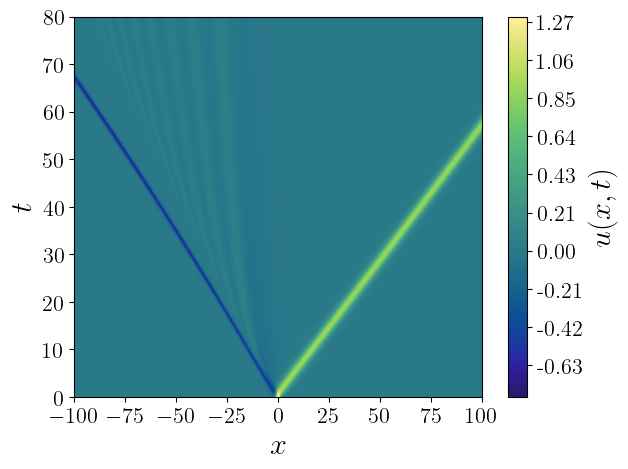

In [11]:
from IPython.display import Image
Image('visuals/' + my_sim.picname, embed=True)

If you're using a script or a Python editor instead of Jupyter, you can also show the image directly by using $\texttt{show\_figure}=\texttt{True}$ in the $\texttt{hov\_plot}$ function. This way of showing the image still works in Jupyter, but it makes the progress bar look funny so I have avoided it here. 

### Saving and Loading Simulations

Here is how to save a simulation: 

In [12]:
my_sim.save()

The file is stored in a folder called $\texttt{sim\_archive}$ instead your current directory: this extra folder is automatically created if it doesn't already exist.  

**WARNING:** saving a $\texttt{simulation}$ object only keeps the $\texttt{model\_kw}$ attribute of the underlying $\texttt{model}$ object. The reason for this admittedly unusual choice has to do with an issue in the "pickle" module that arises from having some flexibility in switching between built-in and custom $\texttt{model}$ objects. So, before you save a simulation, make sure you won't need to compute the symbol or the forcing term from the underlying model!   

This automatically saves the simulation (using the pickle module... for an intro to pickle see https://docs.python.org/3/library/pickle.html) in a folder called "sim_archive". Again, if the folder isn't there already, the above command will also create it automatically. The reason to use pickle instead of saving the simulation data in a .json file or an .npz file is that pickle easily allows one to save *objects*, not just arrays or dicts. So, when we load an old simulation, we can treat it exactly like a new one: we can extract its attributes, make pictures with it, et cetera: if we just saved the numerical solution as an array in a .npz file, we would lose the benefits of my hard work coding up the $\texttt{simulation}$ class :) 

Once the sim is saved, you can load it as follows: 

In [13]:
my_sim.load()

This takes the existing simulation object and populates its solution values (the attribute $\texttt{Udata}$) with loaded data. From here you can treat it just like a simulation you ran. 

In fact, if you've used *joe* lots and forget what simulations you've already done and which ones you haven't, you can use the lovely function $\texttt{load\_or\_run}$. This looks in $\texttt{sim\_archive}$ for a saved version of the simulation in question and, if found, loads it up. If it doesn't find the simulation in $\texttt{sim\_archive}$, it runs the simulation. Either way, after you execute this function, you will have a $\texttt{simulation}$ object containing simulation data! 

From now on it should be your default way of performing simulations. 

In [14]:
my_sim.load_or_run(verbose=True, save=True) # verbose means 'tell us if you loaded or ran'
# save=True means save the sim if you had to run it, and save=False means don't save if you run it (helpful for debugging)

Saved simulation found, loading saved data.


### Making Movies from a Simulation

If you like, you can also save a movie of your simulation using the code below. The .mp4 file containing the movie also appears in the "visuals" folder. 

Be warned: this can take quite a long time depending on if you want to use TeX to render the labels (this is much costlier than you would think!), how many time steps you saved, and the resolution you're asking for! On my desktop the code block below takes about ten seconds if I don't use TeX and keep a low resolution. 

In [15]:
my_sim.save_movie(dpi=80, usetex=False, fieldcolor='xkcd:cerulean', fieldname='u')

Rendering movie... |████████████████████████████████████████| in 12.9s          


If you don't want to go looking for the file, we can just display it in the notebook without much fuss. 

In [16]:
from IPython.display import Video
Video('visuals/' + my_sim.moviename, embed=True)

You can also save a movie of the solution together with its power spectrum with the following (again, sometimes very slow!) command:

In [17]:
my_sim.save_combomovie(dpi=100, usetex=False, fieldcolor='xkcd:cerulean', speccolor='xkcd:dark orange', fieldname='u')

Rendering combo movie... |████████████████████████████████████████| in 18.1s    


Some minor under-the-hood work may be needed to prevent certain parts of this figure from cluttering other ones. 

In [18]:
Video('visuals/' + my_sim.combomoviename, embed=True)